In [13]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as orb
import numpy as np
import itertools
from math import pi
import time
import matplotlib.pyplot as plt
import h5py

# Continuation
This notebook details the tools relevant to continuation, namely ```continuation``` and ```discretization_continuation```. These allow for constrained/changing the discretization in a controlled/incremental manner. First, as per usual, import some orbits.

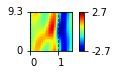

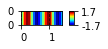

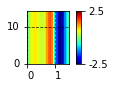

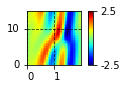

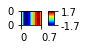

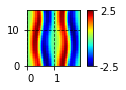

In [14]:
keys = tuple(['defect', 'double_streak', 'drifter', 'large_defect', 'streak', 'wiggle'])

fpos = orb.read_h5('./data/minimal_cover_heterogeneous.h5')

for x in fpos:
    x.plot()

Let's say that we want to numerically continue the first of these, the defect orbit, and see what its continuous family
looks like. We can do this by changing and then constraining its spatial period, `continuation` then sends this to our optimization routines.

In [15]:
defect = fpos[0]
defect.transform(to='modes')

RelativeOrbitKS({"shape": [25, 24], "basis": "modes", "parameters": [9.301, 13.091, -3.798]})

In [16]:
t0=time.time_ns()/10**9
spatial_cont_result = orb.continuation(defect.transform(to='modes'),
                                       {'x': defect.x-0.1},
                                       verbose=False,
                                       step_size=0.01,
                                       tol=1e-4,
                                       methods=('adj', 'lstsq'))
t1=time.time_ns()/10**9
print(f"Spatial continuation took {t1-t0} seconds.")

Spatial continuation took 12.999387502670288 seconds.


The original dimensions were (9.30084486170837, 13.091078488252624)


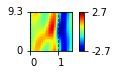

The new dimensions are (23.077853345723334, 12.991078488252626)


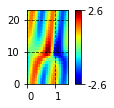

In [17]:
print(f"The original dimensions were {defect.dimensions()}")
defect.plot()
print(f"The new dimensions are {spatial_cont_result.orbit.dimensions()}")
spatial_cont_result.orbit.plot()

After we have this result in hand, you may ask: "why did we fix space and not time"? That's a good question; the temporal period changes during the continuation and so we could have chosen it as our continuation constraint. Actually, it is likely a better choice to accomplish the same goal due to the fact that it is not present in the nonlinear term! To demonstrate, let's
continue our original orbit to the same temporal period as the previous result. 

In [18]:
t0=time.time_ns()/10**9
temporal_cont_result = orb.continuation(defect.transform(to='modes'),
                                        {'t': spatial_cont_result.orbit.t}, 
                                        methods='lstsq',
                                        verbose=False,
                                        step_size=5,
                                        tol=1e-4)
t1=time.time_ns()/10**9
print(f"Temporal continuation took {t1-t0} seconds.")

Temporal continuation took 5.044829845428467 seconds.


The original dimensions were (9.30084486170837, 13.091078488252624)


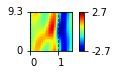

The new dimensions are (23.077853345723334, 12.99507880778735)


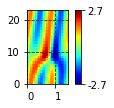

In [19]:
print(f"The original dimensions were {defect.dimensions()}")
defect.plot()
print(f"The new dimensions are {temporal_cont_result.orbit.dimensions()}")
temporal_cont_result.orbit.plot()

The first demonstration is that temporal continuation, fixing the temporal period, can be used instead of spatial continuation
which is less likely to succeed, *if* the temporal period corresponding to the spatial size is known. In other words,
if we want to get to $L=22$ from $L=18$, we can use temporal continuation if we know $T(L)|_{L=22}$.

An astute observer may notice that the solutions are not *exactly* the same. Why? The spatial shift parameters are different;
we never specified a particular phase of the Fourier modes, and so the fields can be slightly different due to interpolation
errors that arise from rotations.

# Discretization continuation

As orbits are used in tandem, it can also be useful to rediscretize and converge the result in order to make the discretized grids as similar as possible. This is accessible through ```discretization_continuation```;
provide the new discretization and then the function will try to incrementally reach a converged orbit with that size of discretization.

This function of course takes keyword arguments for the `hunt` function, the main keywords of importance 
for discretization continuation is the keyword `cycle` and keyword `axes_order`. This dictates the increment strategy to use.
If going from (16, 16)-> (32, 64), the shape goes to (16, 64) and then (32, 64) unless `cycle=True`, at which point discretization will cycle through the axes in order specified by the user via `axes_order` keyword argument.

For example: `axes_order=(1, 0)`, `initial_shape = (16, 16)`, `target_shape = (32, 64)` would rediscretize in sequence

$(16, 18) \to (18,18) \to (18,20) \to\; ... \to (32, 64)$

If, of course, the increment is specified to be 2 in each dimension.

In [ ]:
rpo = orb.read_h5('./data/RelativeOrbitKS.h5')[177]

In [ ]:
defect = defect.transform(to='modes')
disccon = orb.discretization_continuation(rpo, (48,48), verbose=True,
                                          methods='lstsq',
                                          maxiter=10000)
larger_defect = disccon.orbit

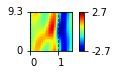

(9.30084486170837, 13.091078488252624)


In [27]:
defect.plot()
print(defect.dimensions())

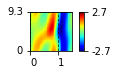

(9.30084486170837, 13.091078488252624)


In [28]:
larger_defect.plot()
print(defect.dimensions())

# Generating continuous families

The fact that orbits come defined on "rubbery tiles", that is, continuous families parameterized by 
This is also automated through the ```span_family``` function. This function requires bounds, step_sizes, and the orbit to serve as the "root" of the branches.

In [29]:
# root_orbits = orb.read_h5('./data/minimal_cover_heterogeneous.h5')

# covering_families = []
# for name, window in zip(keys, root_orbits):
#     if name not in ['streak', 'double_streak']:
#         print(name)
#         bounds = {'t': (window.t//2, 2*window.t)}
#         step_sizes = {'t': 0.01}
#         window = hunt(window.transform(to='modes'), methods='lstsq', tol=1e-10).orbit
#         family_cont = span_family(window, bounds=bounds, step_sizes=step_sizes, tol=[1e-4, 1e-6],
#                                   maxiter=[25000, 200], sampling_rate=10,
#                 verbose=False, methods=('adj', 'lstsq'), ftol=0, preconditioning=True,
#                 filename='covering_heterogeneous.h5', groupname=name, h5mode='a')
#         covering_families.append(family_cont)
#     else:
#         print(name)
#         bounds = {'x': (window.x, 2*window.x)}
#         step_sizes = {'x': 0.1}     
#         window = hunt(window.transform(to='modes').resize(1, 12), methods='lstsq', tol=1e-10).orbit
#         family_cont = span_family(window, bounds=bounds, step_sizes=step_sizes, tol=[1e-4, 1e-6], maxiter=[25000, 200],
#                 verbose=False, methods=('adj', 'lstsq'), ftol=0, preconditioning=True, sampling_rate=10,
#                 filename='covering_heterogeneous.h5', groupname=name, h5mode='a')
#         covering_families.append(family_cont)